Here we build the network of attitudes (Question+Answer) per legislature. Also, we analyze modularity with Louvain algorithm. Results are stored in cluster_analysis.

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.stats as stt
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
from networkx.algorithms import community as nx_community
import community as community_louvain
from collections import Counter
import igraph as ig
import leidenalg
import datetime

In [3]:
def analyze_edge_weights(G, title="Network"):
    edges = []
    for u, v, data in G.edges(data=True):
        w = data.get("weight", None)
        if w is not None and np.isfinite(w):
            edges.append((u, v, float(w)))
    if not edges:
        print(f"[{title}] No finite 'weight' attributes found on edges.")
        return None

    dfw = pd.DataFrame(edges, columns=["u", "v", "weight"])

    # Summary
    desc = dfw["weight"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    #print(f"\n[{title}] Edge weight summary:")
    #print(desc.to_string())

    # # Top/bottom edges
    # top_n = 10
    # print(f"\n[{title}] Top {top_n} edges by weight:")
    # print(dfw.sort_values("weight", ascending=False).head(top_n).to_string(index=False))

    # print(f"\n[{title}] Bottom {top_n} edges by weight:")
    # print(dfw.sort_values("weight", ascending=True).head(top_n).to_string(index=False))

    # Histogram
    plt.figure(figsize=(8, 4))
    plt.hist(dfw["weight"], bins=50, color="#1f77b4", alpha=0.75, edgecolor="white")
    plt.title(f"{title} - Edge Weight Distribution")
    plt.xlabel("weight")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

    # # If similarities in [0,1], zoom in high range
    # if dfw["weight"].min() >= 0 and dfw["weight"].max() <= 1:
    #     plt.figure(figsize=(8, 4))
    #     plt.hist(dfw["weight"], bins=np.linspace(0.7, 1.0, 31), color="#ff7f0e", alpha=0.75, edgecolor="white")
    #     plt.title(f"{title} - Edge Weights (zoom 0.7–1.0)")
    #     plt.xlabel("weight")
    #     plt.ylabel("count")
    #     plt.tight_layout()
    #     plt.show()

    # Node-level average incident weight
    avg_w_by_node = {}
    for n in G.nodes():
        ws = []
        for _, nbr, data in G.edges(n, data=True):
            w = data.get("weight", None)
            if w is not None and np.isfinite(w):
                ws.append(float(w))
        avg_w_by_node[n] = np.mean(ws) if ws else np.nan
    avg_w_series = pd.Series(avg_w_by_node, name="avg_incident_weight").dropna()

    print(f"\n[{title}] Node-level avg incident weight:")
    print(avg_w_series.describe().to_string())

    return dfw

In [20]:
def make_dummy_coded_df(df_nodes):
    """Efficient dummy encoding for a dataframe of categorical values."""
    df = df_nodes.copy()

    # Store all dummy columns in a dict first (avoids fragmentation)
    dummy_dict = {}

    for col in df.columns:
        values = df[col].unique()
        for value in values:
            name = f"{col}:{value}"
            dummy_dict[name] = (df[col] == value).astype(int)  # store as 0/1 ints

    # Concatenate once → no fragmentation
    df_dummy = pd.concat(dummy_dict, axis=1)

    return df_dummy

def phi_(n11,n00,n10,n01):
    n1p = n11+n10
    n0p = n01+n00
    np1 = n01+n11
    np0 = n10+n00
    
    num = n11*n00-n10*n01
    den_ = n1p*n0p*np0*np1
    
    if den_==0:
        phi_=np.nan
    else:
        phi_ = num/np.sqrt(den_)
    return phi_

def p_val(r,L):
    den = np.sqrt(1-r**2)
    deg_free = L-2
    if den==0:
        p = 0
    else:
        num = r*np.sqrt(deg_free)
        t = num/den
        p = stt.t.sf(abs(t), df=deg_free)*2
    return p

def phi(x,y,get_p=False):
    
    m_eq = x==y
    m_diff = np.logical_not(m_eq)
    
    n11 = float(np.sum(x[m_eq]==True))
    n00 = float(np.sum(x[m_eq]==False))
    
    n10 = float(np.sum(x[m_diff]==True))
    n01 = float(np.sum(y[m_diff]==True))
    
    phi_val = phi_(n11,n00,n10,n01)
    
    if get_p:
        p = p_val(phi_val,len(x))
        return phi_val, p
    else:
        return phi_val


def make_graph_(df, list_of_nodes, alpha=0.05, get_p=True, remove_nan=False, remove_non_significant=False, exclude_same_question=True, print_=False):
    
    if get_p==False and remove_non_significant==True:
        print("Warning: Setting remove_non_significant to False as get_p is False!")
        remove_non_significant=False
    
    G = nx.Graph()
    
    count = 0
    # only select 30 nodes
    list_of_nodes = list_of_nodes # here you could select a subset of the nodes
    for i, node_i in enumerate(list_of_nodes):
        for j, node_j in enumerate(list_of_nodes):
            
            if j <= i: # do not run the same couple twice
                continue
            
            if print_:
                count += 1
                l = len(list_of_nodes)
                n_tot = l*(l-1)/2
                print(count,"/",n_tot, " = ", np.round(count/n_tot,decimals=2)*100, '%')
                
            basename1 = node_i.split(sep=':')[0]
            basename2 = node_j.split(sep=':')[0]
            
            if exclude_same_question:
                if basename1 == basename2: # if they belong to the same item
                    continue

            # Get the two columns
            c1 = df[node_i]
            c2 = df[node_j]
            
            if remove_nan:
                if ("Ref" in node_i) or ("Ref" in node_j):
                    continue
                
                c1_n = df[basename1+":nan"] # get the refused values of each item
                c2_n = df[basename2+":nan"]
                
                mask = np.logical_not(np.logical_or(c1_n, c2_n)) # get a mask of the refused values
                
                c1 = c1[mask] # select only the non-nan element
                c2 = c2[mask]
            
            if get_p:
                (r,p) = phi(c1,c2, get_p=True)
            else:
                r = phi(c1,c2, get_p=False)
            
            # Check if there are the conditions for drawing a node
            if remove_non_significant: 
                condition = r>0 and p<alpha
            else:
                condition = r>0

            if condition:
                G.add_weighted_edges_from([(node_i,node_j,r)],weight='weight')
                if get_p:
                    G.add_weighted_edges_from([(node_i,node_j,p)],weight='p')
                    sig = float(p<alpha) # Boolean are not accepted as edge weight
                    G.add_weighted_edges_from([(node_i,node_j,sig)],weight='sig')
    return G

def make_thermo_rep(df0):
    # 1️⃣  Detect the party/group column in df0
    party_candidates = [
        "member.group.short_label", "member.group.label", "member.group.code",
        "party_family", "party", "group_short", "group_label", "group_code",
    ]
    party_col = next((c for c in party_candidates if c in df0.columns), None)
    assert party_col is not None, "❌ No party/group column found in df0."

    # 2️⃣  Define ideology scores (−1 = left ... +1 = right)
    party_axis = {
        # Far Left
        "GUE/NGL": -1.0,
        "GUE_NGL": -1.0,
        "Confederal Group of the European United Left - Nordic Green Left": -1.0,
        "The Left": -1.0,

        # Green Left
        "Greens/EFA": -0.8,
        "GREEN_EFA": -0.8,
        "Group of the Greens/European Free Alliance": -0.8,
        "Greens/European Free Alliance": -0.8,

        # Centre-Left
        "S&D": -0.6,
        "SD": -0.6,
        "Group of the Progressive Alliance of Socialists and Democrats in the European Parliament": -0.6,
        "Socialist Group in the European Parliament": -0.6,

        # Liberal / Centrist
        "Renew": -0.2,
        "RENEW": -0.2,
        "Renew Europe": -0.2,
        "Group of the Alliance of Liberals and Democrats for Europe": -0.2,
        "ALDE": -0.2,

        # Centre-Right (Christian Democrats)
        "EPP": 0.4,
        "European People’s Party": 0.4,
        "European People\u2019s Party": 0.4,
        "Group of the European People's Party (Christian Democrats)": 0.4,
        "Group of the European People's Party (Christian Democrats) and European Democrats": 0.4,
        "EPP-ED": 0.4,

        # Conservative / Right-wing
        "ECR": 0.7,
        "European Conservatives and Reformists": 0.7,
        "European Conservatives and Reformists Group": 0.7,

        # Right-wing populist / Nationalist
        "PFE": 0.9,
        "Patriots for Europe": 0.9,
        "ESN": 0.8,
        "Europe of Sovereign Nations": 0.8,

        # Far-right / Eurosceptic
        "ID": 1.0,
        "Identity & Democracy": 1.0,
        "Europe of Nations and Freedom Group": 1.0,
        "Europe of Freedom and Direct Democracy Group": 1.0,
        "Europe of freedom and democracy Group": 1.0,
        "Independence/Democracy Group": 1.0,
        "Union for Europe of the Nations Group": 0.8,

        # Non-attached
        "NI": 0.0,
        "Non-attached": 0.0,
        "Non-attached Members": 0.0,

        # Handle missing
        np.nan: 0.0
    }

    # 3️⃣  Align df0 with df_dummy (same MEP order)
    if df0.index.name == df_dummy.index.name and df0.index.isin(df_dummy.index).any():
        mep_party = df0[party_col]
    elif "mep_id" in df0.columns and df_dummy.index.name == "mep_id":
        mep_party = df0.set_index("mep_id")[party_col]
    else:
        mep_party = df0[party_col]

    common_ids = df_dummy.index.intersection(mep_party.index)
    X = df_dummy.loc[common_ids].fillna(False).astype(bool)
    parties = mep_party.loc[common_ids].astype(str)

    # 4️⃣  Build MEP-level heat vector (ideology score per MEP)
    mep_heat = parties.map(party_axis).astype(float)
    mep_heat = mep_heat.where(~mep_heat.isna(), 0.0)  # treat unknown as neutral (0.0)

    # 5️⃣  Define correlation helper (ignore NaNs)
    def corr_nan(x, y):
        """Compute Pearson r, ignoring NaN values."""
        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)
        mask = ~np.isnan(x) & ~np.isnan(y)
        if mask.sum() < 3:
            return (0.0, 1.0)
        r, p = stt.pearsonr(x[mask], y[mask])
        return (r, p)

    # 6️⃣  Compute correlation of each node’s endorsement pattern with ideology
    dic_r = {}
    type_ = "standard"  # "standard" for real r, "sign" for ±1 only

    for node in X.columns:
        col_node = X[node].astype(float)  # 0/1 per MEP
        r, p = corr_nan(col_node, mep_heat)
        dic_r[node] = np.sign(r) if type_ == "sign" else r

    # 7️⃣  Attach as node attribute in your network
    nx.set_node_attributes(G, dic_r, "ThermoRep_mean")

    # 8️⃣  Optional: inspect or save
    df_heat = pd.DataFrame.from_dict(dic_r, orient="index", columns=["ThermoRep"])
    #print(df_heat.head())

    # # # 9️⃣  Optional: visualize (red = left, blue = right)
    # import matplotlib.pyplot as plt
    # import matplotlib.colors as mcolors

    # norm = mcolors.Normalize(vmin=-1, vmax=1)
    # cmap = plt.cm.coolwarm
    # colors = [cmap(norm(df_heat.loc[n, "ThermoRep"])) if n in df_heat.index else (0.8, 0.8, 0.8) for n in G.nodes()]

    # plt.figure(figsize=(8, 8))
    # nx.draw(G, node_color=colors, node_size=40, with_labels=False)
    # plt.title("Left–Right Heat (Red=Left, Blue=Right)")
    # plt.axis("off")
    # plt.show()

def get_x_y_coordinates(G):
    pos = nx.spring_layout(G,iterations=5000) # Get the positions with the spring layout

    # Restructure the data type
    pos2 = [[],[]]
    key_list = [] # ordered list of the nodes
    for key in pos:
        pos2[0].append(pos[key][0])
        pos2[1].append(pos[key][1])
        key_list.append(key)

    # Use PCA to rotate the network in such a way that the x-axis is the main one
    pos3 = []
    for key in pos:
        pos3.append([pos[key][0],pos[key][1]])

    pca = PCA(n_components=2)
    pca.fit(pos3)
    x_pca = pca.transform(pos3)

    # Get the x and y position of each node
    xx = x_pca[:,0]
    yy = x_pca[:,1]

    dict_term = nx.get_node_attributes(G,"ThermoRep_mean") # get the feeling thermo
    thermo = [dict_term[key] for key in key_list]
    spearman_corr, spearman_p = stt.spearmanr(xx,thermo)
    return xx, yy

def plot_network(G, title):
    # get positions
    pos = nx.spring_layout(G, iterations=5000)
    nx.draw(G, pos, with_labels=False, node_size=20, width=0.1, edge_color='grey')
    plt.title(title)
    plt.show()


In [ ]:
# Here we perform cluster analysis, partition, modularity, etc.
def cluster_analysis(G, ep_number):


    partition = community_louvain.best_partition(G)
    # Size of communities

    com_sizes = Counter(partition.values())
    print("Louvain communities:", dict(com_sizes))
    modularity = community_louvain.modularity(partition, G)
    print(f"Modularity (Louvain): {modularity:.3f}")
    # Add cluster to networkx graph as node attribute for visualization
    nx.set_node_attributes(G, partition, "louvain_comm")


    gi = ig.Graph.TupleList(G.edges(), directed=False)
    leiden_partition = leidenalg.find_partition(gi, leidenalg.ModularityVertexPartition)
    leiden_modularity = leiden_partition.modularity
    print(f"Modularity (Leiden): {leiden_modularity:.3f}")
    node_labels = {gi.vs[idx]["name"]: cid for idx, cid in enumerate(leiden_partition.membership)}
    nx.set_node_attributes(G, node_labels, 'leiden_comm')
    print("Leiden partition sizes:", dict(Counter(leiden_partition.membership)))


    # write all outputs to a file appending
    with open("cluster_analysis.txt", "a") as f:
        f.write(f"EP number: {ep_number}\n")
        f.write(f"Modularity (Louvain): {modularity:.3f}\n")
        f.write(f"Modularity (Leiden): {leiden_modularity:.3f}\n")
        f.write(f"Community sizes: {dict(Counter(partition.values()))}\n")
        f.write(f"Community sizes: {dict(Counter(leiden_partition.membership))}\n")


In [44]:
import concurrent.futures
import datetime
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt

# ------------------------------
# Put your EP-processing code into a function
# ------------------------------
def process_legislature(i):
    today_date = datetime.datetime.now().strftime("%Y%m%d")
    print(f"Starting EP{i}...")

    df0 = pd.read_csv(f"data/all_votes_main_EP{i}.csv", sep=',')
    df0 = df0[df0.isna().sum(axis=1) < 0.5 * df0.shape[1]]

    list_of_node_variables = [c for c in df0.columns if c.isdigit()]
    df_nodes = df0[list_of_node_variables]

    df_dummy = make_dummy_coded_df(df_nodes)
    print(f"EP{i}: Dummy-coded shape: {df_dummy.shape}")

    # Parameters
    remove_nan=False
    get_p=True
    remove_non_significant=False
    alpha=0.05

    valid_suffixes = (':FOR', ':AGAINST', ':ABSTENTION')
    filtered_cols = [col for col in df_dummy.columns if col.endswith(valid_suffixes)]
    filtered_cols = random.sample(filtered_cols, 300)
    df_dummy = df_dummy[filtered_cols]

    G = make_graph_(
        df=df_dummy,
        list_of_nodes=df_dummy.columns,
        alpha=alpha,
        get_p=get_p,
        remove_non_significant=remove_non_significant,
        remove_nan=remove_nan,
        exclude_same_question=False,
        print_=False
    )
    print(f"EP{i}: Graph built.")

    make_thermo_rep(df0)
    print(f"EP{i}: Thermo done.")

    filename = f"EP{i}_{today_date}"
    nx.write_gexf(G, filename + ".gexf")
    print(f"EP{i}: Saved GEXF file.")

    xx, yy = get_x_y_coordinates(G)
    print(f"EP{i}: Coordinates computed.")

    plt.figure(figsize=(9, 9))
    plt.scatter(xx, yy, cmap="coolwarm", s=50, alpha=0.9)
    plt.title(f"Full network EP{i}", fontsize=14, fontweight="bold")
    plt.axis("off")
    plt.show()

    plot_network(G, title=f"Full network EP{i}")
    analyze_edge_weights(G, title=f"Full network EP{i}")
    cluster_analysis(G, ep_number=i)

    print(f"EP{i}: Finished.")
    return f"EP{i} finished."

# ------------------------------
# Parallel execution
# ------------------------------
if __name__ == "__main__":
    EPs = range(6, 11)

    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(process_legislature, EPs))

    print("All legislatures processed!")
    print(results)

Process SpawnProcess-3:
Process SpawnProcess-4:
Process SpawnProcess-1:
Process SpawnProcess-2:
Traceback (most recent call last):
  File "/Users/nicolalorusso/miniconda3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/nicolalorusso/miniconda3/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nicolalorusso/miniconda3/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Users/nicolalorusso/miniconda3/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'process_legislature' on <module '__main__' (built-in)>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/nicolalorusso/miniconda3/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most r

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [44]:
# # find all unique parties of every legislature

# def unique_parties(EP_number):
#     """Find all unique parties of every legislature."""
#     # 1️⃣  Detect the party/group column in df0
#     df_parties = pd.read_csv(f"data/all_votes_EP{EP_number}.csv", sep=',', low_memory=False)

#     # column is named member.group.short_label, get unique values
#     unique_parties = df_parties["member.group.short_label"].unique()
#     #print(unique_parties)
#     return unique_parties

# unique_parties_list = []
# for i in range(6, 10):  
#     unique_parties_list.append(unique_parties(i))

# # flatten the list
# unique_parties = [item for sublist in unique_parties_list for item in sublist]


# print(unique_parties)

[nan, 'Confederal Group of the European United Left - Nordic Green Left', 'Independence/Democracy Group', "Group of the European People's Party (Christian Democrats) and European Democrats", 'Non-attached Members', 'Group of the Alliance of Liberals and Democrats for Europe', 'Socialist Group in the European Parliament', 'Union for Europe of the Nations Group', 'Group of the Greens/European Free Alliance', "Group of the European People's Party (Christian Democrats)", 'Europe of freedom and democracy Group', 'Group of the Greens/European Free Alliance', 'Group of the Alliance of Liberals and Democrats for Europe', 'Group of the Progressive Alliance of Socialists and Democrats in the European Parliament', 'European Conservatives and Reformists Group', 'Non-attached Members', 'Confederal Group of the European United Left - Nordic Green Left', nan, 'Europe of Freedom and Direct Democracy Group', 'Group of the Greens/European Free Alliance', 'Group of the Progressive Alliance of Socialists 

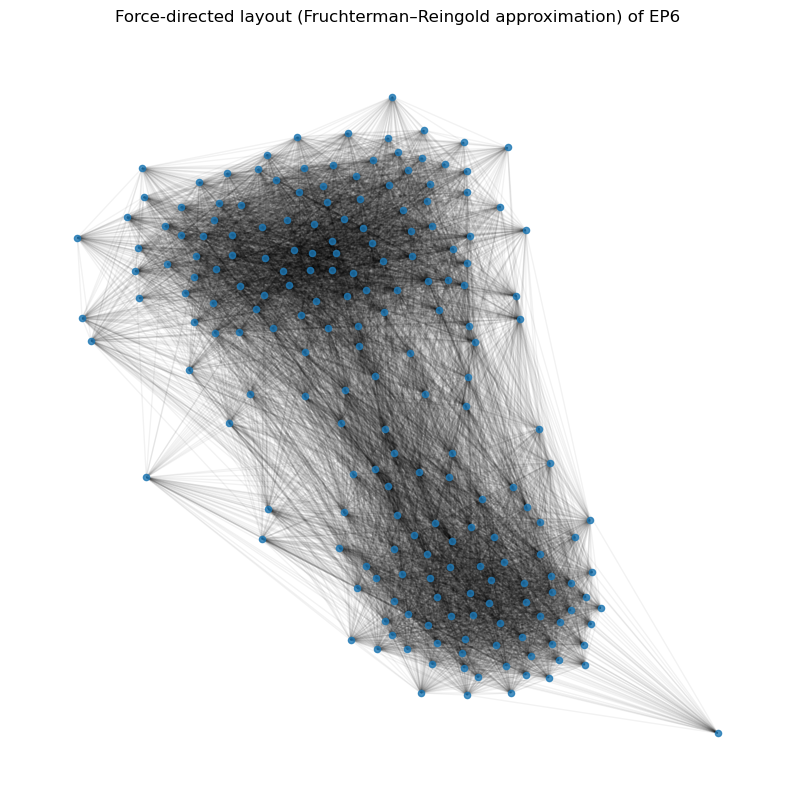

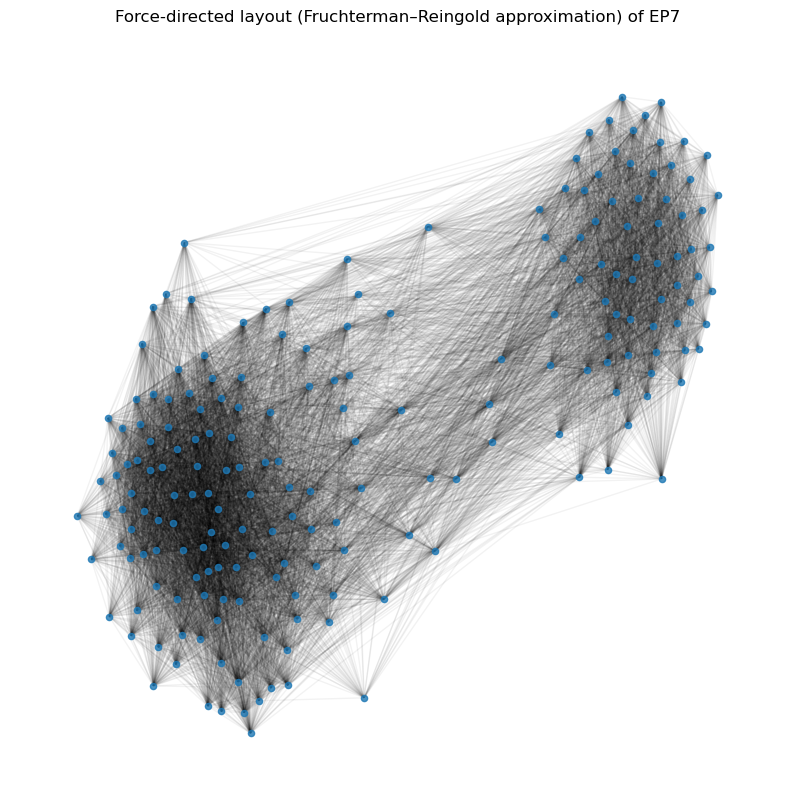

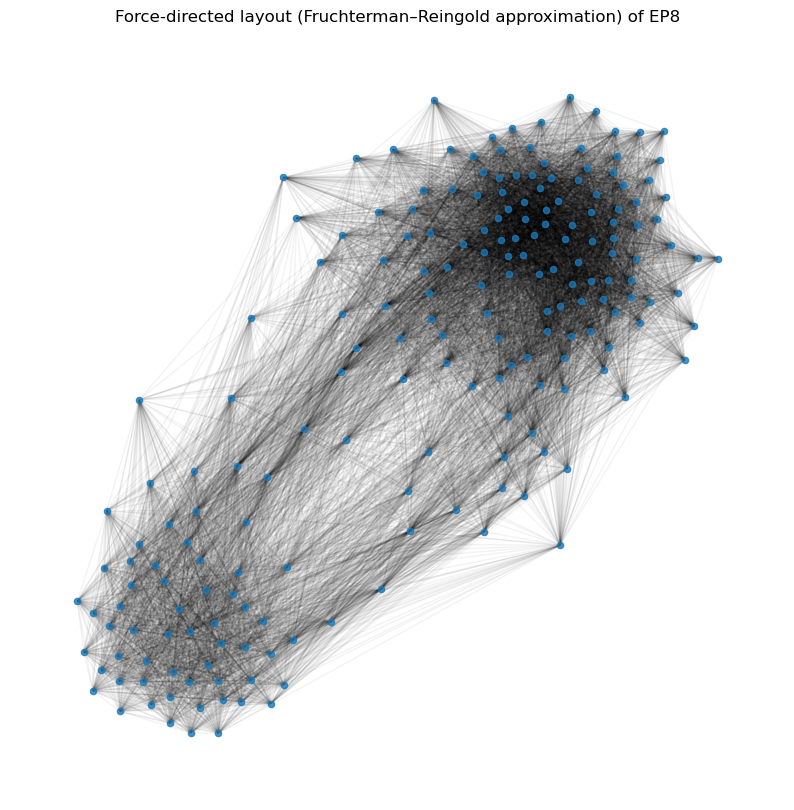

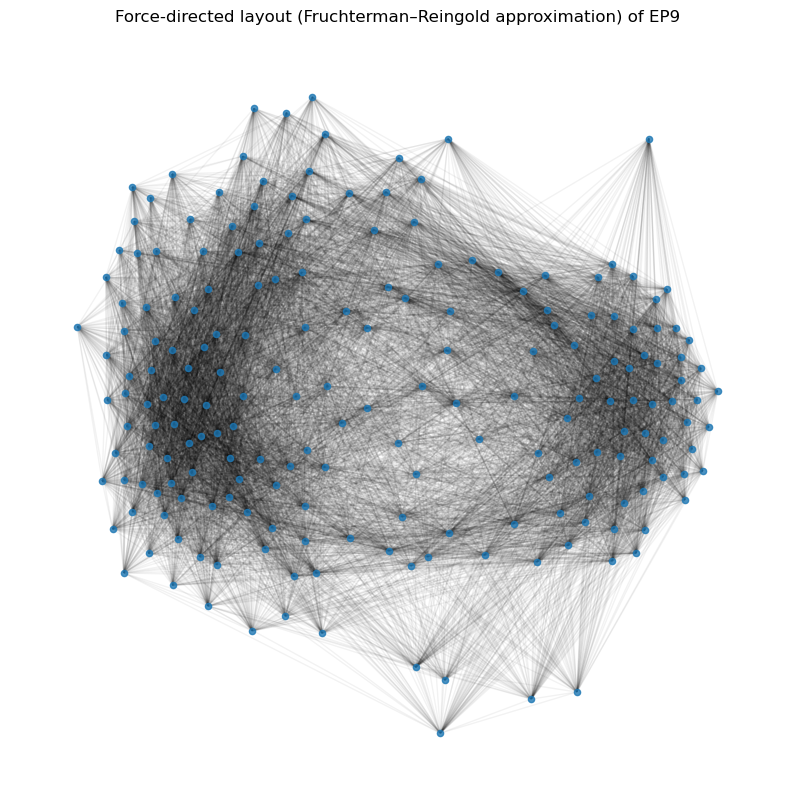

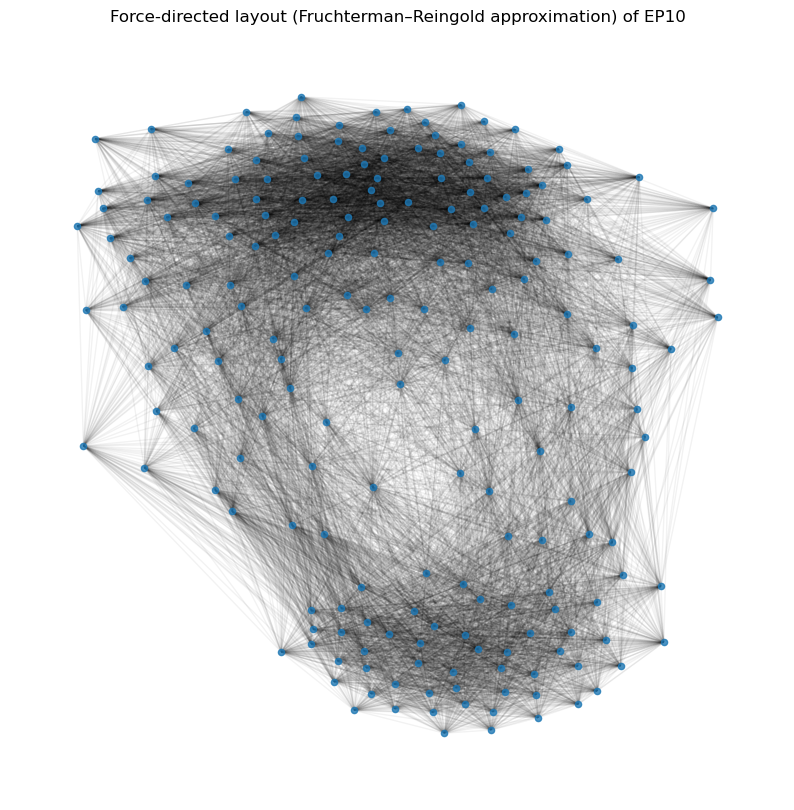

In [80]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_network(G, i):
    G = nx.read_gexf(f"EP{i}_main_votes_20251128.gexf")

    pos = nx.spring_layout(G, k=0.15, iterations=200)  # similar to ForceAtlas2

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, node_size=20, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.05)
    plt.axis('off')
    plt.title("Force-directed layout (Fruchterman–Reingold approximation) of EP" + str(i))
    plt.show()

for i in range(6, 11):
    draw_network(G, i)